In [1]:
# =============================================================================
# BUSINESS-FOCUSED EXPLANATION FOR BEGINNERS
# =============================================================================
print("\n" + "="*80)
print("🎯 BUSINESS GUIDE: UNDERSTANDING METRICS FOR FRAUD DETECTION")
print("="*80)

print("""
📊 CONFUSION MATRIX EXPLAINED:

                    PREDICTED
                 Normal  |  Fraud
    ACTUAL Normal   TN   |   FP     ← Type I Error (False Alarm)
           Fraud    FN   |   TP     ← Type II Error (Missed Fraud)
                    ↑
              Missed Opportunity

• TRUE POSITIVES (TP): Fraudulent transactions correctly identified as fraud ✅
• TRUE NEGATIVES (TN): Normal transactions correctly identified as normal ✅  
• FALSE POSITIVES (FP): Normal transactions incorrectly flagged as fraud ❌
• FALSE NEGATIVES (FN): Fraudulent transactions missed by the model ❌❌""")


🎯 BUSINESS GUIDE: UNDERSTANDING METRICS FOR FRAUD DETECTION

📊 CONFUSION MATRIX EXPLAINED:

                    PREDICTED
                 Normal  |  Fraud
    ACTUAL Normal   TN   |   FP     ← Type I Error (False Alarm)
           Fraud    FN   |   TP     ← Type II Error (Missed Fraud)
                    ↑
              Missed Opportunity

• TRUE POSITIVES (TP): Fraudulent transactions correctly identified as fraud ✅
• TRUE NEGATIVES (TN): Normal transactions correctly identified as normal ✅  
• FALSE POSITIVES (FP): Normal transactions incorrectly flagged as fraud ❌
• FALSE NEGATIVES (FN): Fraudulent transactions missed by the model ❌❌


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load your data (assuming the structure you provided)
DATA_DIR = "../data/processed"
trainX = pd.read_csv(f"{DATA_DIR}/IEEE_Train.csv")
y = pd.read_csv(f"{DATA_DIR}/IEEE_Target.csv")
testX = pd.read_csv(f"{DATA_DIR}/IEEE_Test.csv")

train = trainX.merge(y, on="TransactionID", how="left")
print("Shapes -> train:", train.shape, "test:", testX.shape)

Shapes -> train: (590540, 293) test: (506691, 292)


In [3]:
# Prepare features and target
# Remove TransactionID for modeling
X = train.drop(['TransactionID', 'uid', 'isFraud'], axis=1)
y_target = train['isFraud']

# Check class distribution
print("\nOriginal Class Distribution:")
print(y_target.value_counts())
print(f"Imbalance Ratio: {y_target.value_counts()[0] / y_target.value_counts()[1]:.2f}:1")

# Split the data
# Calculate the split point for 80% of the data
split_point = int(0.8 * len(X))

# Split chronologically - first 80% for training, last 20% for validation
X_train = X[:split_point]
X_val = X[split_point:]
y_train = y_target[:split_point]
y_val = y_target[split_point:]

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nTraining set class distribution:")
print(f"Class 0 (Normal): {sum(y_train == 0)}")
print(f"Class 1 (Fraud): {sum(y_train == 1)}")


Original Class Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Imbalance Ratio: 27.58:1

Training set class distribution:
Class 0 (Normal): 455833
Class 1 (Fraud): 16599


In [4]:
# =============================================================================
# TECHNIQUE 1: BASELINE LOGISTIC REGRESSION (No balancing)
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 1: BASELINE LOGISTIC REGRESSION")
print("="*60)

lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = lr_baseline.predict(X_val_scaled)

print("Baseline Logistic Regression Results:")
print(classification_report(y_val, y_pred_baseline))
auc_baseline = roc_auc_score(y_val, lr_baseline.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_baseline:.4f}")


TECHNIQUE 1: BASELINE LOGISTIC REGRESSION
Baseline Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    114044
           1       0.40      0.26      0.32      4064

    accuracy                           0.96    118108
   macro avg       0.69      0.62      0.65    118108
weighted avg       0.95      0.96      0.96    118108

AUC Score: 0.8291


In [5]:
# =============================================================================
# TECHNIQUE 2: LOGISTIC REGRESSION WITH CLASS WEIGHTS
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 2: LOGISTIC REGRESSION WITH CLASS WEIGHTS")
print("="*60)

lr_weighted = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = lr_weighted.predict(X_val_scaled)

print("Class-Weighted Logistic Regression Results:")
print(classification_report(y_val, y_pred_weighted))
auc_weighted = roc_auc_score(y_val, lr_weighted.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_weighted:.4f}")


TECHNIQUE 2: LOGISTIC REGRESSION WITH CLASS WEIGHTS
Class-Weighted Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.72      0.84    114044
           1       0.09      0.80      0.17      4064

    accuracy                           0.73    118108
   macro avg       0.54      0.76      0.50    118108
weighted avg       0.96      0.73      0.81    118108

AUC Score: 0.8377


In [6]:
# =============================================================================
# TECHNIQUE 3: LOGISTIC REGRESSION WITH SMOTE
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 3: LOGISTIC REGRESSION WITH SMOTE")
print("="*60)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Class distribution:")
print(f"Class 0: {sum(y_train_smote == 0)}")
print(f"Class 1: {sum(y_train_smote == 1)}")

lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_smote.predict(X_val_scaled)

print("SMOTE + Logistic Regression Results:")
print(classification_report(y_val, y_pred_smote))
auc_smote = roc_auc_score(y_val, lr_smote.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_smote:.4f}")


TECHNIQUE 3: LOGISTIC REGRESSION WITH SMOTE
After SMOTE - Class distribution:
Class 0: 455833
Class 1: 455833
SMOTE + Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83    114044
           1       0.09      0.80      0.16      4064

    accuracy                           0.72    118108
   macro avg       0.54      0.76      0.50    118108
weighted avg       0.96      0.72      0.81    118108

AUC Score: 0.8346


In [7]:
# =============================================================================
# TECHNIQUE 4: LOGISTIC REGRESSION WITH RANDOM OVERSAMPLING
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 4: LOGISTIC REGRESSION WITH RANDOM OVERSAMPLING")
print("="*60)

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

print(f"After Random Oversampling - Class distribution:")
print(f"Class 0: {sum(y_train_ros == 0)}")
print(f"Class 1: {sum(y_train_ros == 1)}")

lr_ros = LogisticRegression(random_state=42, max_iter=1000)
lr_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = lr_ros.predict(X_val_scaled)

print("Random Oversampling + Logistic Regression Results:")
print(classification_report(y_val, y_pred_ros))
auc_ros = roc_auc_score(y_val, lr_ros.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_ros:.4f}")


TECHNIQUE 4: LOGISTIC REGRESSION WITH RANDOM OVERSAMPLING
After Random Oversampling - Class distribution:
Class 0: 455833
Class 1: 455833
Random Oversampling + Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.72      0.84    114044
           1       0.09      0.80      0.17      4064

    accuracy                           0.73    118108
   macro avg       0.54      0.76      0.50    118108
weighted avg       0.96      0.73      0.81    118108

AUC Score: 0.8377


In [8]:
# =============================================================================
# TECHNIQUE 5: LOGISTIC REGRESSION WITH RANDOM UNDERSAMPLING
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 5: LOGISTIC REGRESSION WITH RANDOM UNDERSAMPLING")
print("="*60)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

print(f"After Random Undersampling - Class distribution:")
print(f"Class 0: {sum(y_train_rus == 0)}")
print(f"Class 1: {sum(y_train_rus == 1)}")

lr_rus = LogisticRegression(random_state=42, max_iter=1000)
lr_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = lr_rus.predict(X_val_scaled)

print("Random Undersampling + Logistic Regression Results:")
print(classification_report(y_val, y_pred_rus))
auc_rus = roc_auc_score(y_val, lr_rus.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_rus:.4f}")


TECHNIQUE 5: LOGISTIC REGRESSION WITH RANDOM UNDERSAMPLING
After Random Undersampling - Class distribution:
Class 0: 16599
Class 1: 16599
Random Undersampling + Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    114044
           1       0.09      0.80      0.17      4064

    accuracy                           0.73    118108
   macro avg       0.54      0.76      0.50    118108
weighted avg       0.96      0.73      0.82    118108

AUC Score: 0.8398


In [9]:
# =============================================================================
# TECHNIQUE 6: LOGISTIC REGRESSION WITH SMOTEENN (HYBRID METHOD)
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 6: LOGISTIC REGRESSION WITH SMOTEENN (HYBRID)")
print("="*60)

smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)

print(f"After SMOTEENN - Class distribution:")
print(f"Class 0: {sum(y_train_smoteenn == 0)}")
print(f"Class 1: {sum(y_train_smoteenn == 1)}")

lr_smoteenn = LogisticRegression(random_state=42, max_iter=1000)
lr_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)
y_pred_smoteenn = lr_smoteenn.predict(X_val_scaled)

print("SMOTEENN + Logistic Regression Results:")
print(classification_report(y_val, y_pred_smoteenn))
auc_smoteenn = roc_auc_score(y_val, lr_smoteenn.predict_proba(X_val_scaled)[:, 1])
print(f"AUC Score: {auc_smoteenn:.4f}")


TECHNIQUE 6: LOGISTIC REGRESSION WITH SMOTEENN (HYBRID)
After SMOTEENN - Class distribution:
Class 0: 404636
Class 1: 455788
SMOTEENN + Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80    114044
           1       0.08      0.82      0.15      4064

    accuracy                           0.68    118108
   macro avg       0.54      0.75      0.47    118108
weighted avg       0.96      0.68      0.78    118108

AUC Score: 0.8339


In [10]:
# =============================================================================
# TECHNIQUE 7: RANDOM FOREST (HANDLES IMBALANCE NATIVELY)
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 6: RANDOM FOREST WITH BALANCED CLASS WEIGHTS")
print("="*60)

# Random Forest with balanced class weights
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # This handles imbalance automatically
    random_state=42,
    n_jobs=-1
)

# Note: RF doesn't need scaled features
rf_balanced.fit(X_train, y_train)
y_pred_rf = rf_balanced.predict(X_val)

print("Random Forest (Balanced) Results:")
print(classification_report(y_val, y_pred_rf))
auc_rf = roc_auc_score(y_val, rf_balanced.predict_proba(X_val)[:, 1])
print(f"AUC Score: {auc_rf:.4f}")


TECHNIQUE 6: RANDOM FOREST WITH BALANCED CLASS WEIGHTS
Random Forest (Balanced) Results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    114044
           1       0.93      0.28      0.43      4064

    accuracy                           0.97    118108
   macro avg       0.95      0.64      0.71    118108
weighted avg       0.97      0.97      0.97    118108

AUC Score: 0.9295


In [11]:
# =============================================================================
# TECHNIQUE 8: RANDOM FOREST WITH BALANCED SUBSAMPLE
# =============================================================================
print("\n" + "="*60)
print("TECHNIQUE 7: RANDOM FOREST WITH BALANCED SUBSAMPLE")
print("="*60)

rf_subsample = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',  # Balances each bootstrap sample
    random_state=42,
    n_jobs=-1
)

rf_subsample.fit(X_train, y_train)
y_pred_rf_sub = rf_subsample.predict(X_val)

print("Random Forest (Balanced Subsample) Results:")
print(classification_report(y_val, y_pred_rf_sub))
auc_rf_sub = roc_auc_score(y_val, rf_subsample.predict_proba(X_val)[:, 1])
print(f"AUC Score: {auc_rf_sub:.4f}")


TECHNIQUE 7: RANDOM FOREST WITH BALANCED SUBSAMPLE
Random Forest (Balanced Subsample) Results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    114044
           1       0.94      0.28      0.43      4064

    accuracy                           0.97    118108
   macro avg       0.96      0.64      0.71    118108
weighted avg       0.97      0.97      0.97    118108

AUC Score: 0.9310


In [12]:
# =============================================================================
# SUMMARY COMPARISON
# =============================================================================
print("\n" + "="*60)
print("SUMMARY: AUC SCORE COMPARISON")
print("="*60)

results = {
    'Baseline Logistic Regression': auc_baseline,
    'LR + Class Weights': auc_weighted,
    'LR + SMOTE': auc_smote,
    'LR + Random Oversampling': auc_ros,
    'LR + Random Undersampling': auc_rus,
    'LR + SMOTEENN (Hybrid)': auc_smoteenn,
    'Random Forest (Balanced)': auc_rf,
    'Random Forest (Balanced Subsample)': auc_rf_sub
}

for method, score in results.items():
    print(f"{method:<35}: {score:.4f}")

# Find best performing method
best_method = max(results, key=results.get)
print(f"\nBest performing method: {best_method} (AUC: {results[best_method]:.4f})")


SUMMARY: AUC SCORE COMPARISON
Baseline Logistic Regression       : 0.8291
LR + Class Weights                 : 0.8377
LR + SMOTE                         : 0.8346
LR + Random Oversampling           : 0.8377
LR + Random Undersampling          : 0.8398
LR + SMOTEENN (Hybrid)             : 0.8339
Random Forest (Balanced)           : 0.9295
Random Forest (Balanced Subsample) : 0.9310

Best performing method: Random Forest (Balanced Subsample) (AUC: 0.9310)


In [13]:
# =============================================================================
# DETAILED ANALYSIS OF BEST MODEL
# =============================================================================
print("\n" + "="*60)
print("DETAILED ANALYSIS OF BEST MODEL")
print("="*60)

# Determine best model and get its predictions
best_auc = max(results.values())
if results['Random Forest (Balanced)'] == best_auc:
    best_model = rf_balanced
    best_predictions = y_pred_rf
    best_probabilities = rf_balanced.predict_proba(X_val)[:, 1]
    best_name = 'Random Forest (Balanced)'
elif results['Random Forest (Balanced Subsample)'] == best_auc:
    best_model = rf_subsample
    best_predictions = y_pred_rf_sub
    best_probabilities = rf_subsample.predict_proba(X_val)[:, 1]
    best_name = 'Random Forest (Balanced Subsample)'
else:
    # Find the best logistic regression model
    lr_results = {k: v for k, v in results.items() if 'LR' in k or 'Logistic' in k}
    best_lr_method = max(lr_results, key=lr_results.get)
    
    if best_lr_method == 'LR + Class Weights':
        best_model = lr_weighted
        best_predictions = y_pred_weighted
        best_probabilities = lr_weighted.predict_proba(X_val_scaled)[:, 1]
    elif best_lr_method == 'LR + SMOTE':
        best_model = lr_smote
        best_predictions = y_pred_smote
        best_probabilities = lr_smote.predict_proba(X_val_scaled)[:, 1]
    elif best_lr_method == 'LR + SMOTEENN (Hybrid)':
        best_model = lr_smoteenn
        best_predictions = y_pred_smoteenn
        best_probabilities = lr_smoteenn.predict_proba(X_val_scaled)[:, 1]
    # Add other LR models as needed
    best_name = best_lr_method

print(f"Best Model: {best_name} (AUC: {best_auc:.4f})")

# Import additional libraries for advanced metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve

# Calculate metrics
precision, recall, pr_thresholds = precision_recall_curve(y_val, best_probabilities)
fpr, tpr, roc_thresholds = roc_curve(y_val, best_probabilities)
pr_auc = average_precision_score(y_val, best_probabilities)
roc_auc = roc_auc_score(y_val, best_probabilities)


DETAILED ANALYSIS OF BEST MODEL
Best Model: Random Forest (Balanced Subsample) (AUC: 0.9310)


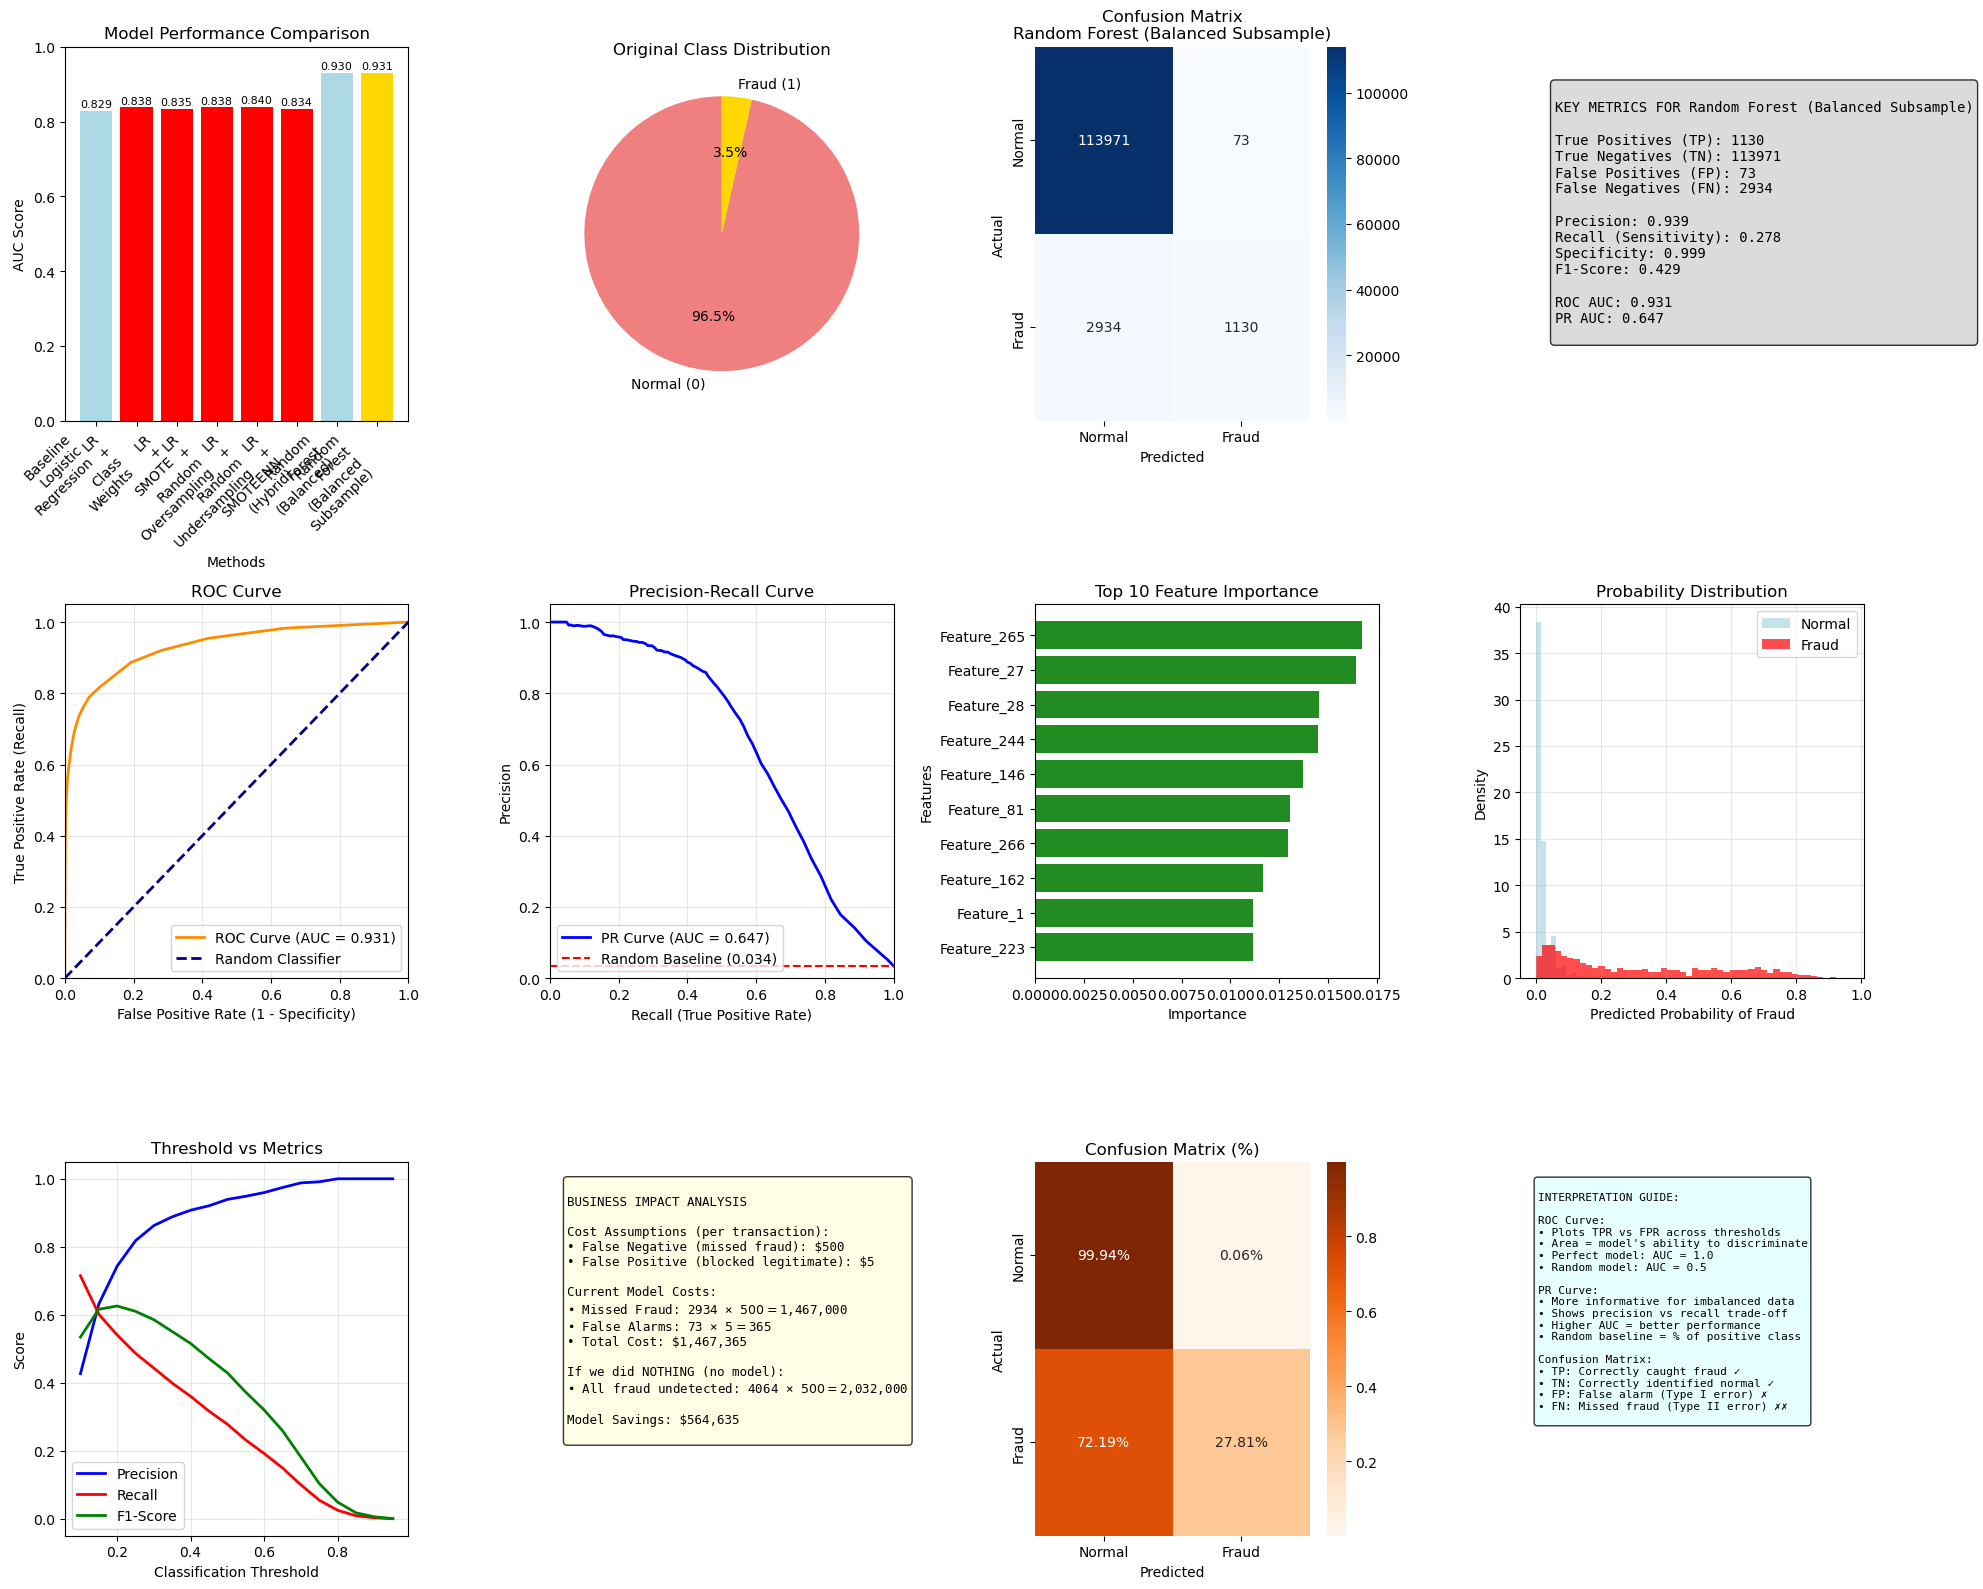

In [14]:

# =============================================================================
# COMPREHENSIVE VISUALIZATIONS
# =============================================================================
fig = plt.figure(figsize=(20, 16))

# 1. AUC Score Comparison
plt.subplot(3, 4, 1)
methods = list(results.keys())
scores = list(results.values())
colors = ['gold' if method == best_name else ('red' if 'LR' in method else 'lightblue') for method in methods]
bars = plt.bar(range(len(methods)), scores, color=colors)
plt.xlabel('Methods')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.xticks(range(len(methods)), [m.replace(' ', '\n') for m in methods], rotation=45, ha='right')
plt.ylim(0, 1)
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', fontsize=8)

# 2. Original Class Distribution
plt.subplot(3, 4, 2)
original_dist = y_target.value_counts()
colors_pie = ['lightcoral', 'gold']
plt.pie(original_dist.values, labels=['Normal (0)', 'Fraud (1)'], autopct='%1.1f%%', 
        startangle=90, colors=colors_pie)
plt.title('Original Class Distribution')

# 3. Confusion Matrix
plt.subplot(3, 4, 3)
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title(f'Confusion Matrix\n{best_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Calculate confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall/True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision_val = tp / (tp + fp)
f1_val = 2 * (precision_val * sensitivity) / (precision_val + sensitivity)

# 4. Key Metrics Display
plt.subplot(3, 4, 4)
plt.axis('off')
metrics_text = f"""
KEY METRICS FOR {best_name}

True Positives (TP): {tp}
True Negatives (TN): {tn}
False Positives (FP): {fp}
False Negatives (FN): {fn}

Precision: {precision_val:.3f}
Recall (Sensitivity): {sensitivity:.3f}
Specificity: {specificity:.3f}
F1-Score: {f1_val:.3f}

ROC AUC: {roc_auc:.3f}
PR AUC: {pr_auc:.3f}
"""
plt.text(0.1, 0.9, metrics_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# 5. ROC Curve
plt.subplot(3, 4, 5)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 6. Precision-Recall Curve
plt.subplot(3, 4, 6)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
# Baseline (random classifier for imbalanced data)
baseline = sum(y_val) / len(y_val)
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Random Baseline ({baseline:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# 7. Feature Importance (if Random Forest)
plt.subplot(3, 4, 7)
if 'Random Forest' in best_name:
    feature_importance = best_model.feature_importances_
    top_features = np.argsort(feature_importance)[-10:]
    plt.barh(range(len(top_features)), feature_importance[top_features], color='forestgreen')
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance')
    plt.yticks(range(len(top_features)), [f'Feature_{i}' for i in top_features])
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available for\nLogistic Regression', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

# 8. Prediction Probability Distribution
plt.subplot(3, 4, 8)
fraud_probs = best_probabilities[y_val == 1]
normal_probs = best_probabilities[y_val == 0]
plt.hist(normal_probs, bins=50, alpha=0.7, label='Normal', color='lightblue', density=True)
plt.hist(fraud_probs, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Density')
plt.title('Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Threshold Analysis
plt.subplot(3, 4, 9)
thresholds = np.arange(0.1, 1.0, 0.05)
precisions, recalls, f1s = [], [], []
for thresh in thresholds:
    y_pred_thresh = (best_probabilities >= thresh).astype(int)
    if sum(y_pred_thresh) > 0:  # Avoid division by zero
        prec = sum((y_pred_thresh == 1) & (y_val == 1)) / sum(y_pred_thresh)
        rec = sum((y_pred_thresh == 1) & (y_val == 1)) / sum(y_val == 1)
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    else:
        prec = rec = f1 = 0
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
plt.plot(thresholds, f1s, 'g-', label='F1-Score', linewidth=2)
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

# 10. Business Cost Analysis
plt.subplot(3, 4, 10)
plt.axis('off')
cost_analysis = f"""
BUSINESS IMPACT ANALYSIS

Cost Assumptions (per transaction):
• False Negative (missed fraud): $500
• False Positive (blocked legitimate): $5

Current Model Costs:
• Missed Fraud: {fn} × $500 = ${fn * 500:,}
• False Alarms: {fp} × $5 = ${fp * 5:,}
• Total Cost: ${fn * 500 + fp * 5:,}

If we did NOTHING (no model):
• All fraud undetected: {sum(y_val == 1)} × $500 = ${sum(y_val == 1) * 500:,}

Model Savings: ${sum(y_val == 1) * 500 - (fn * 500 + fp * 5):,}
"""
plt.text(0.05, 0.95, cost_analysis, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 11-12. Additional visualizations
plt.subplot(3, 4, 11)
# Confusion Matrix as percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(3, 4, 12)
plt.axis('off')
interpretation_text = """
INTERPRETATION GUIDE:

ROC Curve:
• Plots TPR vs FPR across thresholds
• Area = model's ability to discriminate
• Perfect model: AUC = 1.0
• Random model: AUC = 0.5

PR Curve:
• More informative for imbalanced data
• Shows precision vs recall trade-off
• Higher AUC = better performance
• Random baseline = % of positive class

Confusion Matrix:
• TP: Correctly caught fraud ✓
• TN: Correctly identified normal ✓
• FP: False alarm (Type I error) ✗
• FN: Missed fraud (Type II error) ✗✗
"""
plt.text(0.05, 0.95, interpretation_text, transform=plt.gca().transAxes, 
         fontsize=8, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.tight_layout()
plt.show()

In [15]:
# =============================================================================
# KEY INSIGHTS AND RECOMMENDATIONS
# =============================================================================
print("\n" + "="*60)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*60)

print("""
1. LOGISTIC REGRESSION TECHNIQUES:
   - Class weights: Simple and effective, adjusts decision boundary
   - SMOTE: Creates synthetic samples, good for small datasets
   - Random Oversampling: Simple but may cause overfitting
   - Random Undersampling: Fast but loses information

2. RANDOM FOREST ADVANTAGES:
   - Handles imbalance natively with class_weight parameter
   - No need for feature scaling
   - Built-in feature selection
   - Less prone to overfitting
   - 'balanced_subsample' balances each bootstrap sample

3. RECOMMENDATIONS:
   - Start with class_weight='balanced' for both LR and RF
   - Use SMOTE for logistic regression if you have sufficient data
   - Random Forest often performs better on imbalanced datasets
   - Always validate with appropriate metrics (AUC, F1, Precision/Recall)
   - Consider ensemble methods for production systems
""")

# Final model recommendation
print(f"\nRECOMMENDED MODEL: {best_method}")
print("This model achieved the highest AUC score and is suitable for your fraud detection task.")



KEY INSIGHTS AND RECOMMENDATIONS

1. LOGISTIC REGRESSION TECHNIQUES:
   - Class weights: Simple and effective, adjusts decision boundary
   - SMOTE: Creates synthetic samples, good for small datasets
   - Random Oversampling: Simple but may cause overfitting
   - Random Undersampling: Fast but loses information

2. RANDOM FOREST ADVANTAGES:
   - Handles imbalance natively with class_weight parameter
   - No need for feature scaling
   - Built-in feature selection
   - Less prone to overfitting
   - 'balanced_subsample' balances each bootstrap sample

3. RECOMMENDATIONS:
   - Start with class_weight='balanced' for both LR and RF
   - Use SMOTE for logistic regression if you have sufficient data
   - Random Forest often performs better on imbalanced datasets
   - Always validate with appropriate metrics (AUC, F1, Precision/Recall)
   - Consider ensemble methods for production systems


RECOMMENDED MODEL: Random Forest (Balanced Subsample)
This model achieved the highest AUC score and is